In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance # Added for permutation importance

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
df = pd.read_csv(
    "/content/sample_data/household_power_consumption.txt",sep=",",na_values="?",low_memory=False)

df.head()


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.shape
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [5]:
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S"
)

df.drop(["Date", "Time"], axis=1, inplace=True)


In [6]:
numeric_cols = df.columns.drop("datetime")

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [7]:
df.isna().sum()


,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979
datetime,0


In [8]:
df.fillna(df.median(), inplace=True)


In [9]:
df.isna().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0
datetime,0


In [11]:
df.shape


(2075259, 8)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   datetime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [13]:
df["hour"] = df["datetime"].dt.hour
df["day"] = df["datetime"].dt.day
df["month"] = df["datetime"].dt.month
df["weekday"] = df["datetime"].dt.weekday


In [14]:
df["lag_1"] = df["Global_active_power"].shift(1)


In [15]:
df["rolling_24"] = df["Global_active_power"].rolling(24).mean()


In [16]:
df.dropna(inplace=True)


Exploratory Data Analysis

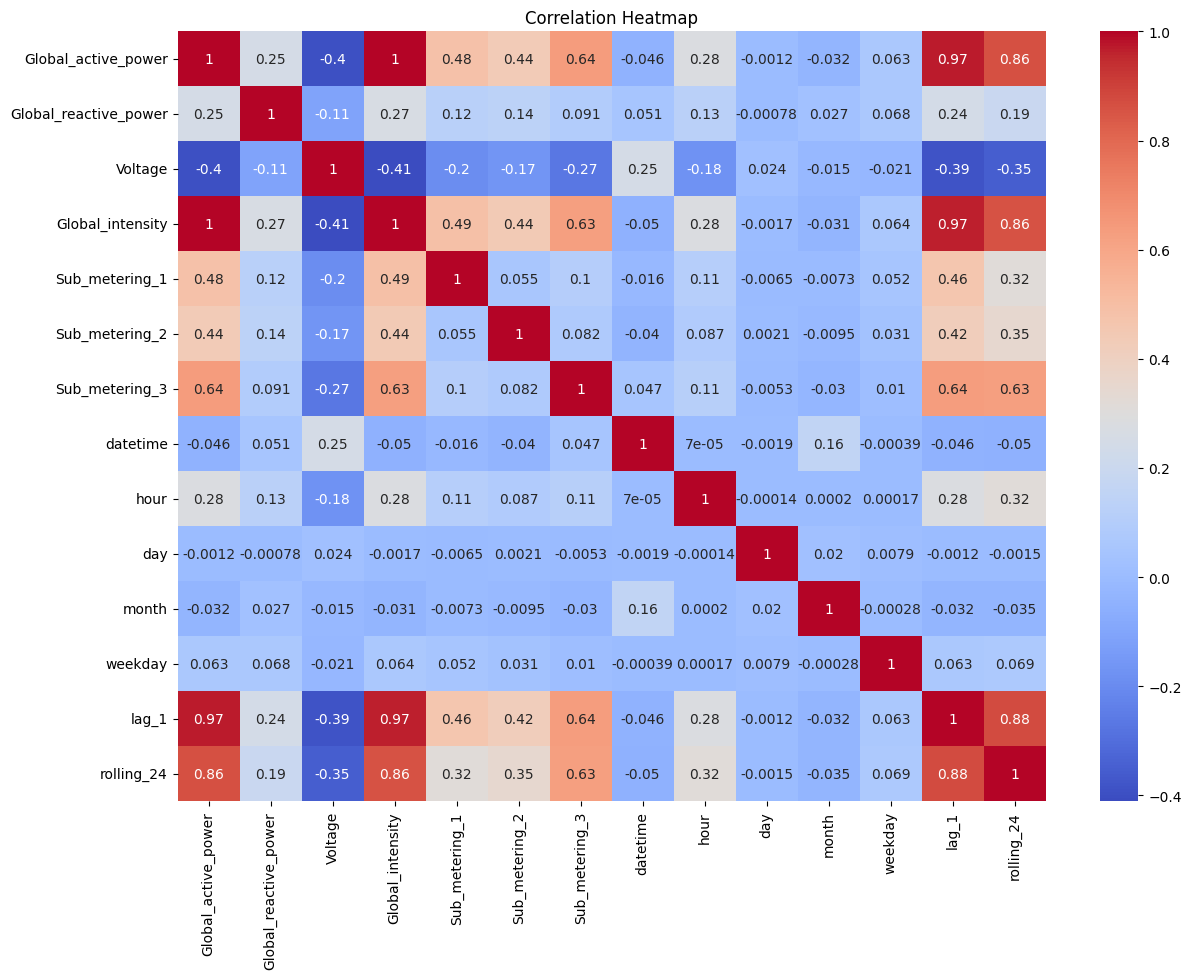

In [18]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(),annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


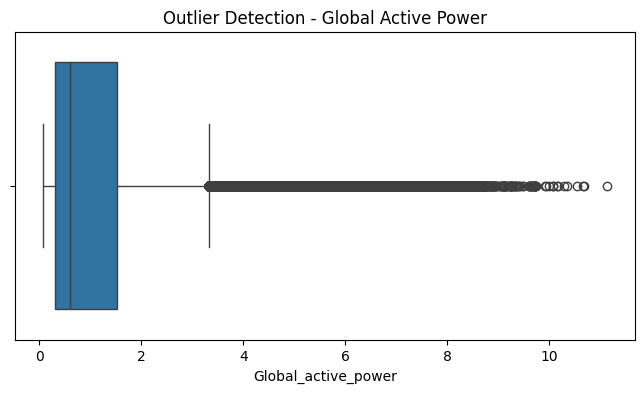

In [27]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df["Global_active_power"])
plt.title("Outlier Detection - Global Active Power")
plt.show()


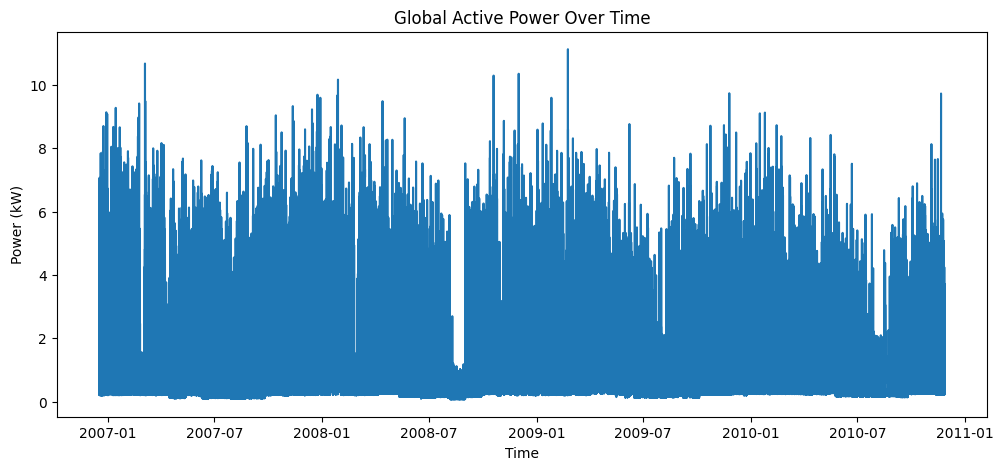

In [19]:
plt.figure(figsize=(12,5))
plt.plot(df["datetime"], df["Global_active_power"])
plt.title("Global Active Power Over Time")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.show()


Data Modelling

In [20]:
X = df.drop(["Global_active_power", "datetime"], axis=1)
y = df["Global_active_power"]


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [22]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)


In [24]:
print("Linear Regression Performance")
print("MAE :", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2  :", r2_score(y_test, y_pred_lr))


Linear Regression Performance
MAE : 0.025077019001136618
RMSE: 0.039683444360557284
R2  : 0.998578529458608


Model-2

In [30]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(
    max_depth=10,
    learning_rate=0.1,
    max_iter=200,
    random_state=42
)

hgb.fit(X_train, y_train)
y_pred = hgb.predict(X_test)


In [32]:
print("HistGradientBoostingRegressor Performance")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2  :", r2_score(y_test, y_pred))

HistGradientBoostingRegressor Performance
MAE : 0.014124423204094141
RMSE: 0.024121493826563187
R2  : 0.9994747965826404


In [40]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "HistGradientBoostingRegressor"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred))
    ],
    "R2": [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred)
    ]
})

results

,Model,MAE,RMSE,R2
0,Linear Regression,0.025077,0.039683,0.998579
1,HistGradientBoostingRegressor,0.014124,0.024121,0.999475
